In [35]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from func_data import *


In [36]:
df=pd.read_csv(r"D:\data\diabetes_012_health_indicators_BRFSS2015.csv")

df.head(10)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


In [37]:
df.rename(columns={"Diabetes_012": "Diabetes"}, inplace=True)

map = {
    0: 0,
    1: 1,
    2: 1,
    
}
df["Diabetes"] = df["Diabetes"].replace(map)


In [38]:
print(df.shape)
df.dropna # odrzucamy wiersze z wartościami NaN
df.shape


(253680, 22)


(253680, 22)

In [39]:
df = df.sample(n=30000)

In [40]:
neg, pos = np.bincount(df['Diabetes'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 30000
    Positive: 4728 (15.76% of total)



In [41]:
df=one_hot_encode_dataframe(df)

In [42]:
train_df, test_df = train_test_split(df, test_size=0.15,random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15,random_state=42)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Diabetes'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Diabetes'))
test_labels = np.array(test_df.pop('Diabetes'))


train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [43]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (21675,)
Validation labels shape: (3825,)
Test labels shape: (4500,)
Training features shape: (21675, 21)
Validation features shape: (3825, 21)
Test features shape: (4500, 21)


In [44]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dense(
          8, activation='relu',
          ),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [45]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)


In [46]:
model = make_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                352       
                                                                 
 dense_19 (Dense)            (None, 8)                 136       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
model.predict(train_features[:10])


1/1 [==============================] - 0s 55ms/step


array([[0.23197769],
       [0.228381  ],
       [0.4214551 ],
       [0.27951854],
       [0.32233378],
       [0.21652874],
       [0.3415877 ],
       [0.31618312],
       [0.2682025 ],
       [0.31279477]], dtype=float32)

In [48]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.5421


In [49]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.67619478])

In [50]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])


1/1 [==============================] - 0s 48ms/step


array([[0.07996165],
       [0.09537949],
       [0.10731182],
       [0.10345514],
       [0.06772804],
       [0.11110853],
       [0.16409212],
       [0.14357708],
       [0.13473615],
       [0.19182332]], dtype=float32)

In [51]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.4391


In [52]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


In [53]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [54]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [55]:
colors = ['b', 'g', 'r'] 
def plot_loss(history, label, n):
    
    # Use a log scale on the y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()  # Add a legend to the plot
    plt.show()    # Display the plot
  


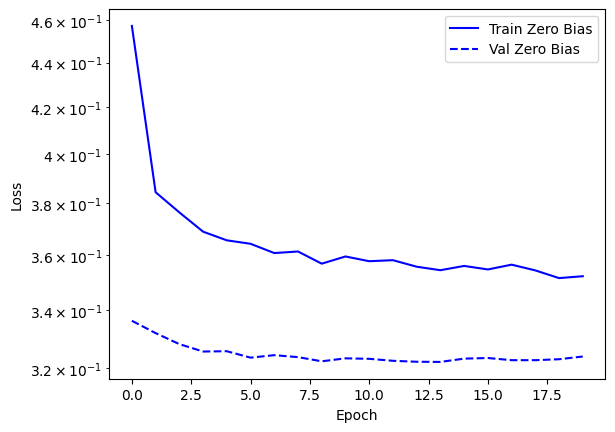

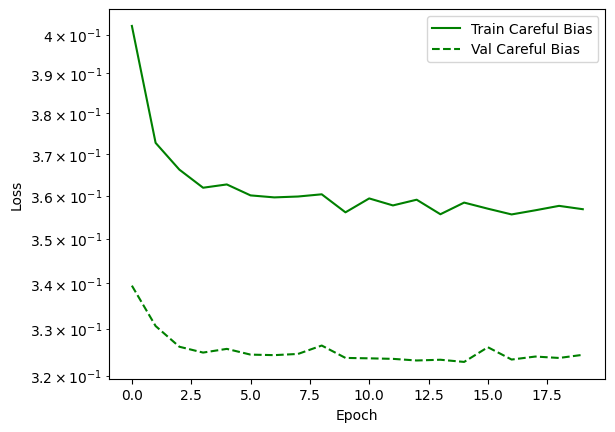

In [56]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [57]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))


Epoch 1/100
678/678 [==============================] - 3s 2ms/step - loss: 0.4031 - tp: 312.0000 - fp: 299.0000 - tn: 21204.0000 - fn: 3685.0000 - accuracy: 0.8438 - precision: 0.5106 - recall: 0.0781 - auc: 0.7258 - prc: 0.3324 - val_loss: 0.3388 - val_tp: 22.0000 - val_fp: 8.0000 - val_tn: 3272.0000 - val_fn: 523.0000 - val_accuracy: 0.8612 - val_precision: 0.7333 - val_recall: 0.0404 - val_auc: 0.8010 - val_prc: 0.4037
Epoch 2/100
678/678 [==============================] - 1s 2ms/step - loss: 0.3744 - tp: 349.0000 - fp: 324.0000 - tn: 17899.0000 - fn: 3103.0000 - accuracy: 0.8419 - precision: 0.5186 - recall: 0.1011 - auc: 0.7754 - prc: 0.3845 - val_loss: 0.3306 - val_tp: 21.0000 - val_fp: 9.0000 - val_tn: 3271.0000 - val_fn: 524.0000 - val_accuracy: 0.8607 - val_precision: 0.7000 - val_recall: 0.0385 - val_auc: 0.8117 - val_prc: 0.4229
Epoch 3/100
678/678 [==============================] - 1s 2ms/step - loss: 0.3671 - tp: 415.0000 - fp: 378.0000 - tn: 17845.0000 - fn: 3037.0000 - a

In [58]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])
    
    plt.legend()
    plt.tight_layout()
    

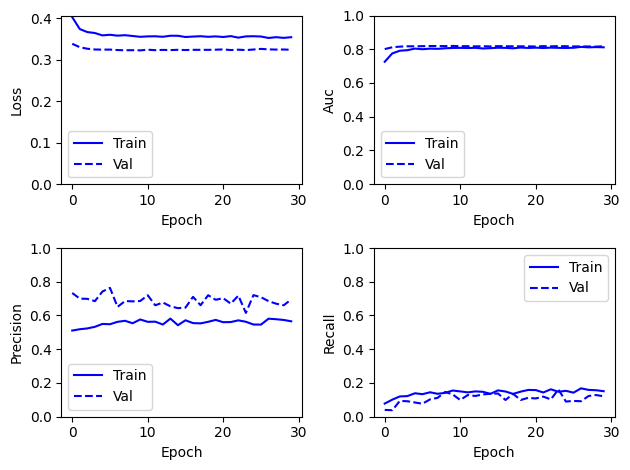

In [59]:
plot_metrics(baseline_history)
plt.show()

In [60]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


141/141 [==============================] - 0s 853us/step


In [61]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

loss :  0.35948804020881653
tp :  83.0
fp :  49.0
tn :  3720.0
fn :  648.0
accuracy :  0.8451111316680908
precision :  0.6287878751754761
recall :  0.11354309320449829
auc :  0.8033227920532227
prc :  0.43421608209609985



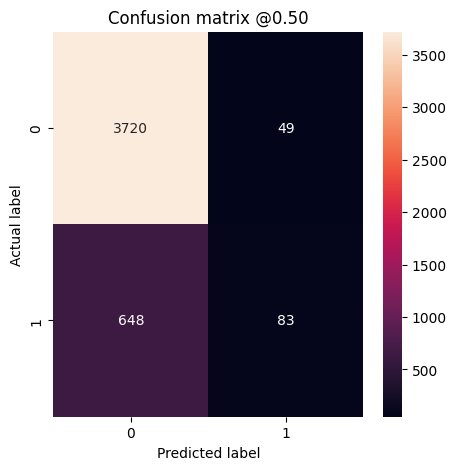

In [62]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


In [63]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([10,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

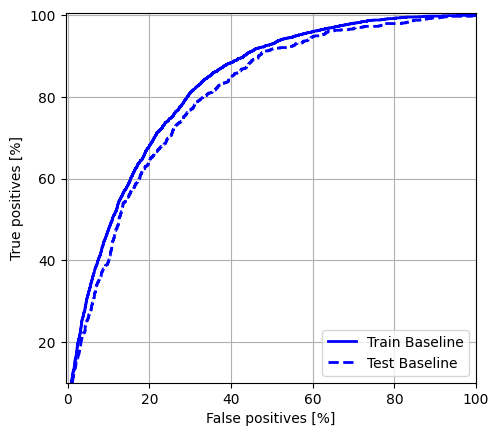

In [64]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [65]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

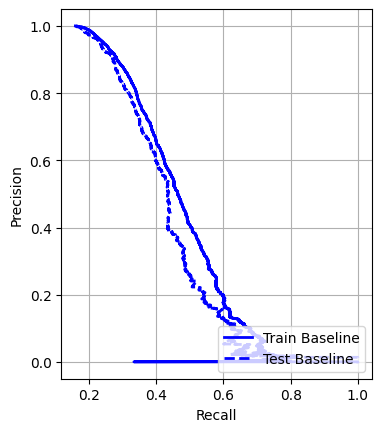

In [66]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [67]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.59
Weight for class 1: 3.17


In [68]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


Epoch 1/100
678/678 [==============================] - 3s 3ms/step - loss: 0.6878 - tp: 1648.0000 - fp: 3205.0000 - tn: 18787.0000 - fn: 2535.0000 - accuracy: 0.7807 - precision: 0.3396 - recall: 0.3940 - auc: 0.7024 - prc: 0.3132 - val_loss: 0.5233 - val_tp: 353.0000 - val_fp: 728.0000 - val_tn: 2552.0000 - val_fn: 192.0000 - val_accuracy: 0.7595 - val_precision: 0.3265 - val_recall: 0.6477 - val_auc: 0.8081 - val_prc: 0.4066
Epoch 2/100
678/678 [==============================] - 1s 2ms/step - loss: 0.5981 - tp: 2014.0000 - fp: 3865.0000 - tn: 14358.0000 - fn: 1438.0000 - accuracy: 0.7553 - precision: 0.3426 - recall: 0.5834 - auc: 0.7702 - prc: 0.3739 - val_loss: 0.5231 - val_tp: 384.0000 - val_fp: 793.0000 - val_tn: 2487.0000 - val_fn: 161.0000 - val_accuracy: 0.7506 - val_precision: 0.3263 - val_recall: 0.7046 - val_auc: 0.8140 - val_prc: 0.4259
Epoch 3/100
678/678 [==============================] - 1s 2ms/step - loss: 0.5808 - tp: 2120.0000 - fp: 4018.0000 - tn: 14205.0000 - fn: 1

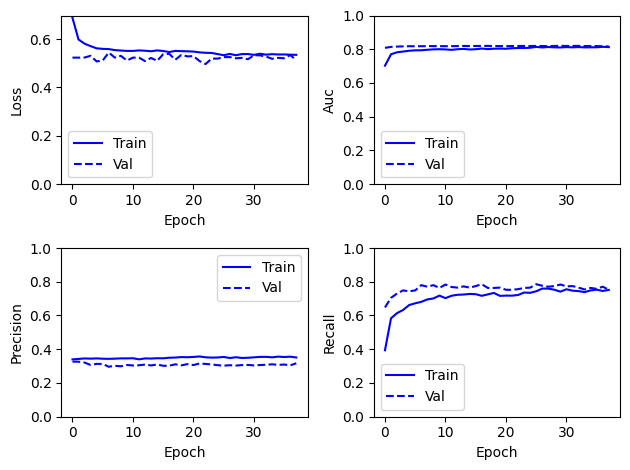

In [69]:
plot_metrics(weighted_history)
plt.show()


In [70]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)


141/141 [==============================] - 0s 935us/step


loss :  0.534478485584259
tp :  556.0
fp :  1073.0
tn :  2696.0
fn :  175.0
accuracy :  0.7226666808128357
precision :  0.3413136899471283
recall :  0.7606019377708435
auc :  0.8042857646942139
prc :  0.43881088495254517



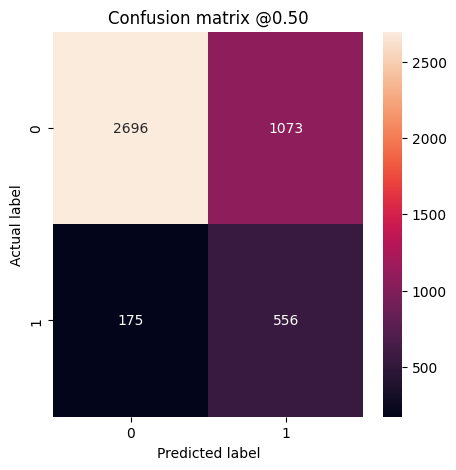

In [71]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

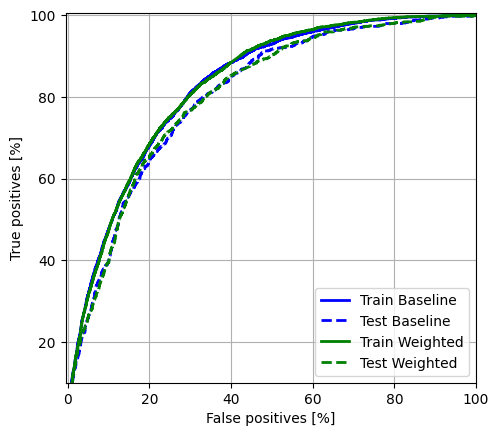

In [72]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');


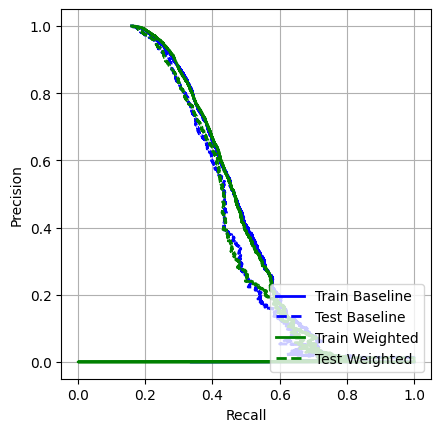

In [73]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');


In [74]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


In [75]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(18223, 21)

In [76]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(36446, 21)

In [77]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


In [78]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())


Features:
 [ 1.15854667  1.17430508  0.19346525 -0.05677364  1.11629476 -0.20813769
 -0.32519919 -1.7721177   0.74962458  0.48343262 -0.2451725   0.22347678
 -0.30511632  2.31593432  2.27121615  2.92271304 -0.45517538  1.13366094
 -0.01114602  0.96265878  0.93709981]

Label:  1.0


In [79]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
  print(label.numpy().mean())


0.40625


In [80]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

1580.0

In [81]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)


Epoch 1/100
1580/1580 [==============================] - 4s 2ms/step - loss: 0.5809 - tp: 18663.0000 - fp: 9256.0000 - tn: 19979.0000 - fn: 7162.0000 - accuracy: 0.7018 - precision: 0.6685 - recall: 0.7227 - auc: 0.7700 - prc: 0.7201 - val_loss: 0.5212 - val_tp: 436.0000 - val_fp: 1081.0000 - val_tn: 2199.0000 - val_fn: 109.0000 - val_accuracy: 0.6889 - val_precision: 0.2874 - val_recall: 0.8000 - val_auc: 0.8171 - val_prc: 0.4306
Epoch 2/100
1580/1580 [==============================] - 3s 2ms/step - loss: 0.5452 - tp: 19486.0000 - fp: 7464.0000 - tn: 17638.0000 - fn: 5972.0000 - accuracy: 0.7343 - precision: 0.7230 - recall: 0.7654 - auc: 0.8010 - prc: 0.7762 - val_loss: 0.5119 - val_tp: 425.0000 - val_fp: 965.0000 - val_tn: 2315.0000 - val_fn: 120.0000 - val_accuracy: 0.7163 - val_precision: 0.3058 - val_recall: 0.7798 - val_auc: 0.8178 - val_prc: 0.4323
Epoch 3/100
1580/1580 [==============================] - 3s 2ms/step - loss: 0.5433 - tp: 18943.0000 - fp: 7052.0000 - tn: 18386.00

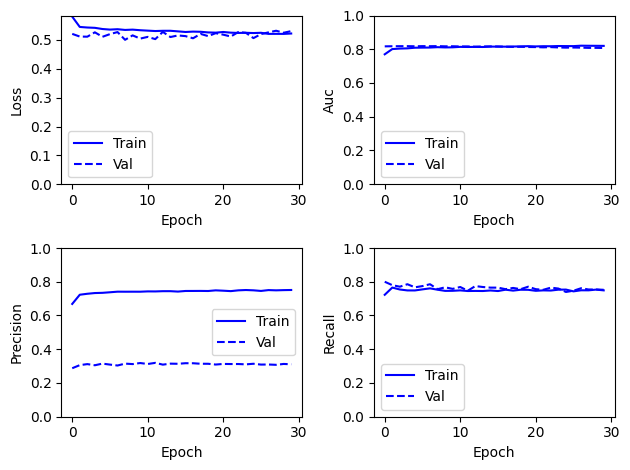

In [82]:
plot_metrics(resampled_history)
plt.show()

In [83]:
esampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))


Epoch 1/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.7776 - tp: 182.0000 - fp: 181.0000 - tn: 143.0000 - fn: 134.0000 - accuracy: 0.5078 - precision: 0.5014 - recall: 0.5759 - auc: 0.5372 - prc: 0.5715 - val_loss: 0.7029 - val_tp: 285.0000 - val_fp: 1518.0000 - val_tn: 1762.0000 - val_fn: 260.0000 - val_accuracy: 0.5352 - val_precision: 0.1581 - val_recall: 0.5229 - val_auc: 0.5583 - val_prc: 0.2305
Epoch 2/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.7382 - tp: 180.0000 - fp: 164.0000 - tn: 160.0000 - fn: 136.0000 - accuracy: 0.5312 - precision: 0.5233 - recall: 0.5696 - auc: 0.5622 - prc: 0.5961 - val_loss: 0.7047 - val_tp: 304.0000 - val_fp: 1521.0000 - val_tn: 1759.0000 - val_fn: 241.0000 - val_accuracy: 0.5393 - val_precision: 0.1666 - val_recall: 0.5578 - val_auc: 0.5846 - val_prc: 0.2417
Epoch 3/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.7204 - tp: 173.0000 - fp: 136.0000 - tn: 170.0000 - fn: 161.0000 - ac

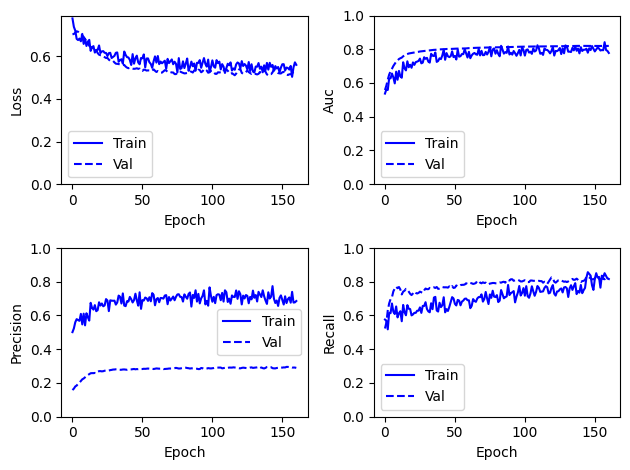

In [84]:
plot_metrics(resampled_history)
plt.show()

141/141 [==============================] - 0s 1ms/step
loss :  0.5339864492416382
tp :  576.0
fp :  1236.0
tn :  2533.0
fn :  155.0
accuracy :  0.6908888816833496
precision :  0.3178808093070984
recall :  0.7879617214202881
auc :  0.8021771311759949
prc :  0.4259141683578491



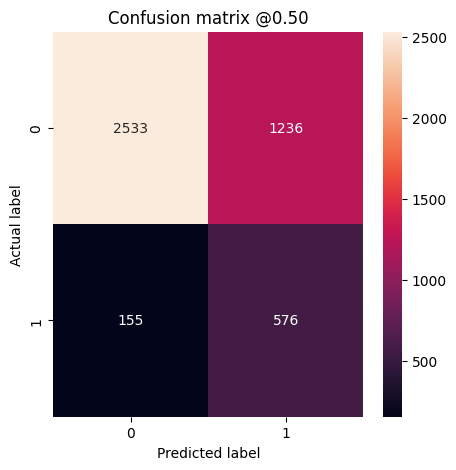

In [85]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)


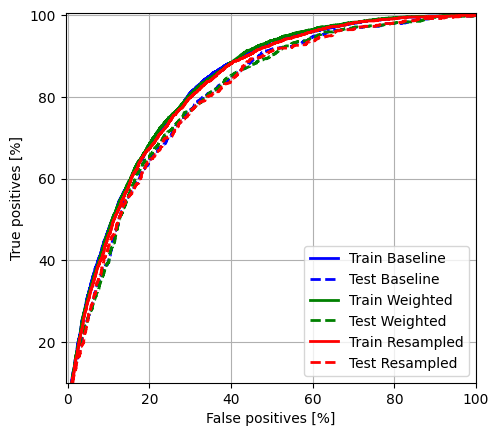

In [86]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');


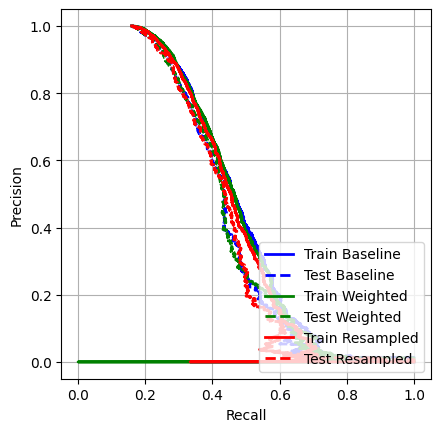

In [87]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');
